<a href="https://colab.research.google.com/github/columose/Chronic-Pain-Project/blob/main/MNE_ERP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import mne

In [ ]:
# Create participant folders and filenames

folder=[]
filename=[]
i=[]
for i in range(1,16,1):
    i +=1
    folder.append(f'EEG{i}')
    filename.append(f'EEG{i}_PE_interp.set')

print(filename)

['EEG2_PE_interp.set', 'EEG3_PE_interp.set', 'EEG4_PE_interp.set', 'EEG5_PE_interp.set', 'EEG6_PE_interp.set', 'EEG7_PE_interp.set', 'EEG8_PE_interp.set', 'EEG9_PE_interp.set', 'EEG10_PE_interp.set', 'EEG11_PE_interp.set', 'EEG12_PE_interp.set', 'EEG13_PE_interp.set', 'EEG14_PE_interp.set', 'EEG15_PE_interp.set', 'EEG16_PE_interp.set']


In [ ]:
# Load pre-processed data, equalise trial count across conditions, create trial average
All_data = []

for isub in range(len(filename)):
    data_path = rf'D:\Jorge\Data\1.Raw_data'
    file = rf'{data_path}\{folder[isub]}\{filename[isub]}'

    # Read pre-processed data
    raw = mne.io.read_epochs_eeglab(file)

    # Equalise trials across conditions prior to averaging
    raw.equalize_event_counts(raw.event_id)

    # Create trial average per subject
    ERP_avg = [raw[key].average() for key in sorted(raw.event_id.keys())]  # sorted as B4 may come first

    # Append condition average to list per subject
    All_data.append(ERP_avg) # All_data[sub][cond]

In [ ]:
# Create condition comparison difference waves for paired sample t test
# Where condition comparisons are deviant [1] - standard [0] and omission [2] - omission standard [3]

comps = [1,0],[2,3] # Indices of our condition comparisons
diff_waves = []

for icomp in range(len(comps)):
    diff_waves.append([mne.combine_evoked([All_data[subj][comps[icomp][0]], # condition 1
                                      All_data[subj][comps[icomp][1]]       # condition 2
                                     ],
                                     weights=[1, -1]
                                     )
                  for subj in range(len(All_data))
                  ])
diff_waves

In [ ]:
# Convert difference waveforms to numpy arrays with subjects x timepoint x channel matrices for permutation based statistics

Diff_waves_data = []
for icomp in range(len(comps)):
    temp = []
    temp = np.swapaxes(np.array([e.get_data()          # swap axes is crucial as the data must be stored as subs x time x chans
                          for e in diff_waves[icomp]
                          ]
                         ),1,2)

    Diff_waves_data.append(temp) #Diff_waves_data[comparison][data] for indexing purposes

Diff_waves_data[0].shape # Ensure the shape is [subjects, timepoints, channels] for permutation testing


(15, 975, 64)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 64


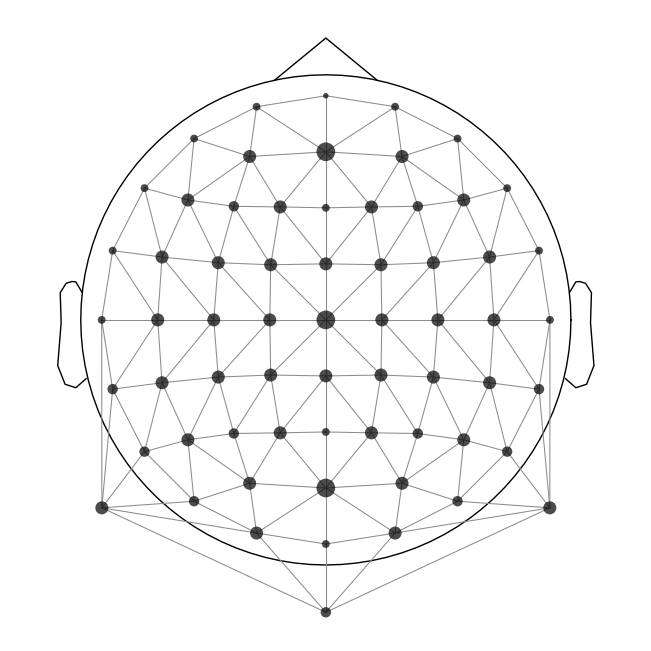

In [ ]:
# Create neighbour template for clusters
from mne.channels import find_ch_adjacency, make_1020_channel_selections

adjacency, ch_names = find_ch_adjacency(raw.info, ch_type='eeg')
mne.viz.plot_ch_adjacency(raw.info, adjacency, ch_names=ch_names);


In [ ]:
# Run cluster based permutation paired samples t test

from mne.stats import spatio_temporal_cluster_1samp_test

n_perm = 1000

t_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_1samp_test(
    Diff_waves_data[0],
    adjacency=adjacency,
    n_permutations=n_perm,
    out_type='mask',
    n_jobs=-1,
    verbose='Info'
    )

Using a threshold of 2.144787
stat_fun(H1): min=-9.308986 max=8.153374
Running initial clustering …
Found 277 clusters


C:\Users\colum\AppData\Local\Temp\ipykernel_20528\2670310185.py:7: RuntimeWarning: joblib not installed. Cannot run in parallel.
  t_obs, clusters, cluster_pv, H0 = spatio_temporal_cluster_1samp_test(


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [ ]:
# find significant points across all clusters

mask_idx = np.where(cluster_pv < 0.05)[0]
mask = [clusters[idx] for idx in mask_idx]

# stats output is time X chan, but ERP data is chan X time, so transpose
transpose_mask = mask[0].T

Identifying common channels ...


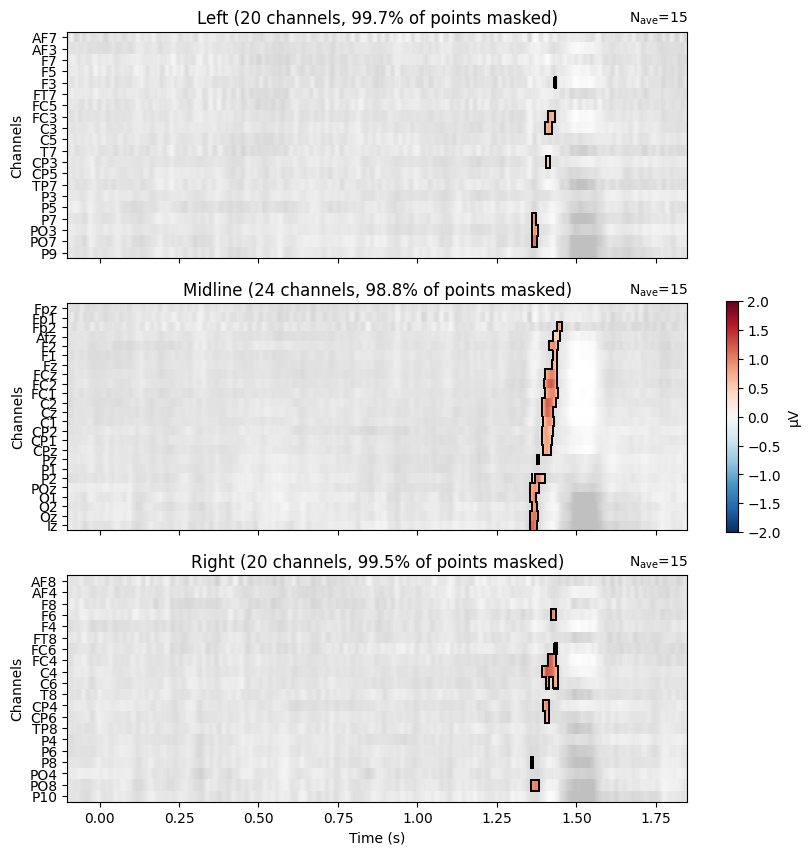

In [ ]:
# Create raster plots to show channel-time points in which the standard and deviant conditions differ

from mne.channels import find_ch_adjacency, make_1020_channel_selections

# Create ROIs by checking channel labels
selections = make_1020_channel_selections(diff_waves[0][0].info, midline="12z")
time_unit = dict(time_unit="s")

fig, axes = plt.subplots(nrows=3, figsize=(10,10))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
mne.grand_average(diff_waves[0]).plot_image(axes=axes,
                            group_by=selections,
                            colorbar=False,
                            show=False,
                            mask=transpose_mask,
                            show_names="all",
                            titles=None,
                            **time_unit,
                            clim = dict(eeg=[-2, 2])
                            )

plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")

plt.show()

In [ ]:
# Obtain significant channel and time indices
sig_points = np.argwhere(transpose_mask == True) # significant channel-time points

chan_idx = []
time_idx = []
for ipnt in range(len(sig_points)):      # Loop through significant channel-time point pairs
    chan_idx.append(sig_points[ipnt][0]) # first dimension is channel, second is timepoint
    time_idx.append(sig_points[ipnt][1])

chan_idx = np.unique(chan_idx)
time_idx = np.unique(time_idx)

print(chan_idx)
print(time_idx)

[ 3  4  9 10 11 12 17 18 22 24 25 26 27 28 29 30 31 33 36 37 38 40 43 44
 45 46 47 48 49 50 53 54 55 56 59 61 63]
[727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744
 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762
 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777]


Identifying common channels ...


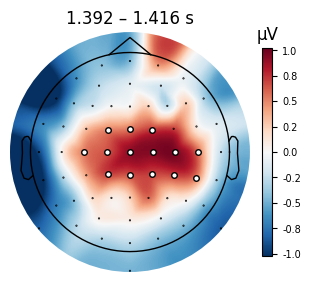

In [ ]:
# Topoplot averaged over significant time range

# Obtain significant times in seconds from time indices
time = np.linspace(-0.100, 1.848, 975)
sig_time = (time[time_idx[0]] + time[time_idx[-1]])/2 # Indices of first and last significant time points

mne.grand_average(diff_waves[0]).plot_topomap(times=sig_time,
                                             average=0.025,
                                             mask=transpose_mask,
                                             contours=False,
                                             sensors=True,
                                             size=2,
                                            );

In [ ]:
# Create standard and deviant conditions from All_data variable for plotting purposes

Std = []
Dev = []
for isub in range(len(All_data)):
    Std.append(All_data[isub][0])
    Dev.append(All_data[isub][1])

evoked = {'Standard':Std, 'Deviant':Dev}

In [ ]:
# Convert channel indices to strings

roi = []
for ch in chan_idx:
    roi.append(raw.info['ch_names'][ch])

combining channels using "mean"
combining channels using "mean"


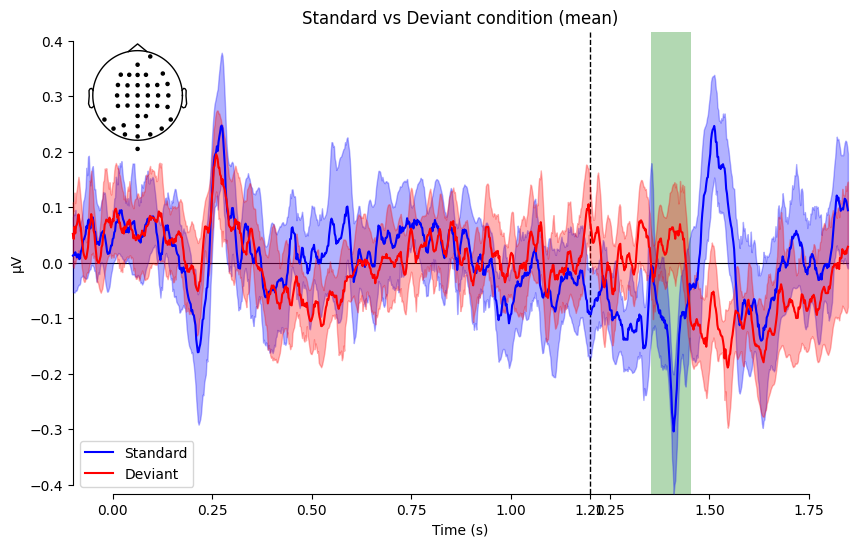

In [ ]:
# Create a subplot with one axis
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Define color dictionary
color_dict = {'Standard': 'blue', 'Deviant': 'red'}

# Define time points
time = np.linspace(-0.100, 1.848, 975)

# Mark starting point of unexpected omission
yline = [1.2]

# Plot the evoked responses and capture the returned axis object
mne.viz.plot_compare_evokeds(evoked,
                             combine='mean',
                             legend='lower left',
                             picks=roi,
                             show_sensors='upper left',
                             colors=color_dict,
                             title='Standard vs Deviant condition',
                             vlines=yline,
                             axes=axs,
                             show=False # This is essential to enable the axvspan attribute to work
                             )

# Add the shaded region to the correct axis
axs.axvspan(time[time_idx[0]], time[time_idx[-1]], facecolor='green', alpha=0.3)

# Ensure tight layout and then display the plot
plt.show()